In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [2]:
batch_size = 200
epochs = 300
no_cuda = False
seed = 1
log_interval = 50

cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(seed)

In [3]:
# CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./cifar10_data/', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./cifar10_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data/


In [4]:
device = torch.device("cuda" if cuda else "cpu")

In [5]:
class VAE_CNN(nn.Module):
    def __init__(self):
        super(VAE_CNN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(8 * 8 * 16, 2048)
        self.fc_bn1 = nn.BatchNorm1d(2048)
        self.fc21 = nn.Linear(2048, 2048)
        self.fc22 = nn.Linear(2048, 2048)

        # Sampling vector
        self.fc3 = nn.Linear(2048, 2048)
        self.fc_bn3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, 8 * 8 * 16)
        self.fc_bn4 = nn.BatchNorm1d(8 * 8 * 16)

        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        # print("=========ENCODE:")
        conv1 = self.relu(self.bn1(self.conv1(x)))
        # print("CONV1: ",conv1.shape)
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        # print("CONV2: ",conv2.shape)
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        # print("CONV3: ",conv3.shape)
        conv4 = self.relu(self.bn4(self.conv4(conv3)))
        # print("CONV4: ",conv4.shape)
        conv4 = conv4.view(-1, 8 * 8 * 16)
        # print("CONV4 VIEW: ",conv4.shape)
        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        # print("FC1: ",fc1.shape)
        r1 = self.fc21(fc1)
        # print("R1: ",r1.shape)
        r2 = self.fc22(fc1)
        # print("R2: ",r2.shape)
        
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        # print("=========DECODE:")
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        # print("FC3: ",fc3.shape)
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))
        # print("FC4: ",fc4.shape)
        fc4 = fc4.view(-1, 16, 8, 8)
        # print("FC4 VIEW: ",fc4.shape)
        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        # print("CONV5: ",conv5.shape)
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        # print("CONV6: ",conv6.shape)
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        # print("CONV7: ",conv7.shape)
        conv8 = self.conv8(conv7)
        # print("CONV8: ",conv8.shape)
        conv8 = conv8.view(-1, 3, 32, 32)
        # print("CONV8 VIEW: ",conv8.shape)
        return conv8

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [7]:
model = VAE_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [8]:
loss_mse = customLoss()

In [9]:
val_losses = []
train_losses = []

In [10]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))
    train_losses.append(train_loss / len(train_loader.dataset))

In [11]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_mse(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 3, 32, 32)[:n]])
                save_image(comparison.cpu(),
                           'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)

In [12]:
os.mkdir('results')

In [13]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2048).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 3, 32, 32),
                   'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/50000 (0%)]	Loss: 3427.068125
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1198.334219
Train Epoch: 1 [20000/50000 (40%)]	Loss: 671.292109
Train Epoch: 1 [30000/50000 (60%)]	Loss: 561.801680
Train Epoch: 1 [40000/50000 (80%)]	Loss: 535.431875
====> Epoch: 1 Average loss: 1367.5264
====> Test set loss: 1422.6386
Train Epoch: 2 [0/50000 (0%)]	Loss: 597.897109
Train Epoch: 2 [10000/50000 (20%)]	Loss: 520.614531
Train Epoch: 2 [20000/50000 (40%)]	Loss: 511.560664
Train Epoch: 2 [30000/50000 (60%)]	Loss: 395.098906
Train Epoch: 2 [40000/50000 (80%)]	Loss: 438.975547
====> Epoch: 2 Average loss: 477.1401
====> Test set loss: 399.0190
Train Epoch: 3 [0/50000 (0%)]	Loss: 395.827969
Train Epoch: 3 [10000/50000 (20%)]	Loss: 428.824648
Train Epoch: 3 [20000/50000 (40%)]	Loss: 380.560898
Train Epoch: 3 [30000/50000 (60%)]	Loss: 400.280312
Train Epoch: 3 [40000/50000 (80%)]	Loss: 382.944922
====> Epoch: 3 Average loss: 402.1756
====> Test set loss: 380.7100
Train Epoch: 4 [0/50000 (0%

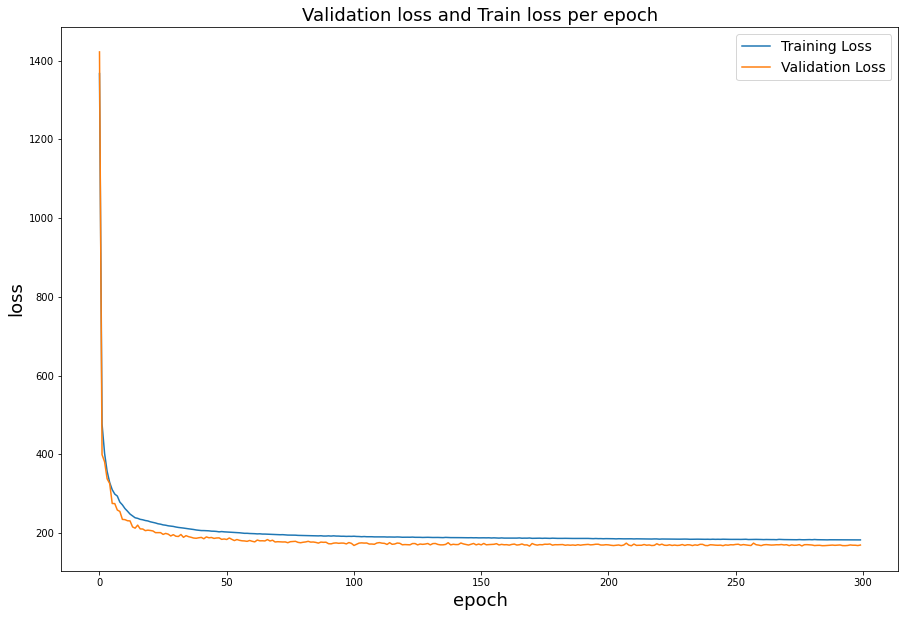

In [14]:
plt.figure(figsize=(15,10))
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(val_losses)),val_losses)
plt.title("Validation loss and Train loss per epoch",fontsize=18)
plt.xlabel("epoch",fontsize=18)
plt.ylabel("loss",fontsize=18)
plt.legend(['Training Loss','Validation Loss'],fontsize=14)
plt.show()

In [16]:
torch.min(torch.Tensor(train_losses))

tensor(182.2318)

In [17]:
torch.min(torch.Tensor(val_losses))

tensor(166.5153)